# Analyzing Student Responses to Circuits Questions using Latent Dirichlet Allocation

### Jon Geiger

## I. Introduction: Topic Modeling for Student Reponses in Physics

In this notebook, we will perform a machine learning analysis of student responses to a particular conceptual question about circuits in undergraduate physics. 

We will be using Latent Dirichlet Allocation (LDA) to pull out topics, which should represent student ideas. Much of the code and process for this analysis can be credited to Tor Odden and Allesandro Marin at the University of Oslo, who have graciously provided a Jupyter Notebook outlining the process of cleaning and modeling data from 18 years' worth of PERC proceedings (https://github.com/uio-ccse/PERC_TopicModel). Changes have been made as necessary, and certain modeling techniques have been excluded, such as the time variance of topics, as well as providing exemplary documents for each modeled topic. 

## II. Data Cleaning and Preparation

### Setting Notebook Options

In [1]:
# Print out all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wider Cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

### Importing Packages

In [15]:
%matplotlib inline

# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle as pkl
import copy

# NLP Packages
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import wordnet
from nltk import pos_tag

# Download NLTK data
nltk.download('wordnet', quiet = True)
nltk.download('punkt', quiet = True) 
nltk.download('averaged_perceptron_tagger', quiet = True)
nltk.download('omw-1.4', quiet = True)

# Custom Helper Functions
import sys  
sys.path.insert(0, 'scripts')
from helper_functions import plot_freq_dist,get_top_n_words,plot_words_freq

True

True

True

True

### Importing and Cleaning Data

For the purposes of our investigation, we found that many student reponses included some form of the equation of Ohm's Law. These took the three distinct forms of $V=IR$, $I=V/R$, and $R=V/I$. While we could replace each of these equations with a "word" representation such as `VequalsItimesR` or `IequalsVoverR`, we found that this did not contribute much to the final topic distributions. Additionally, because these equations are domain-specific, we would require different data cleaning steps if we were to tackle problems from, say, Heat & Temperature or Momentum.

In [3]:
df = pd.read_csv('data/compare_bulbs.csv', names = ['ID', 'resp'])
df.drop(columns = ['ID'], inplace = True)
df.head(5)

,resp
0,Circuit 2 has a larger battery that has a grea...
1,If the voltage is increased but resistance rem...
2,Current is equal to charge over time. Move vol...
3,An increase in voltage indicates an increase i...
4,Voltage is the change in electric potential. C...


In [4]:
def ML_process(text): 
    filt_text = text
    
    # Clean up equations
    # filt_text = re.sub('(V|v)\s?=\s?(I|i)\s?\*?\s?(R|r)', 'VequalsItimesR', filt_text)
    # filt_text = re.sub('(I|i)\s?=\s?(V|v)\s?/\s?(R|r)', 'IequalsVoverR', filt_text)
    # filt_text = re.sub('(R|r)\s?=\s?(V|v)\s?/\s?(I|i)', 'RequalsVoverI', filt_text)
    #filt_text = re.sub('\s?=\s?', '=', filt_text)
    
    # Replace variables with names outside of equations
    # filt_text = re.sub('\s(V|v)\s', ' voltage ', filt_text)
    # filt_text = re.sub('\s(R|r)\s', ' resistance ', filt_text)  
    # can't do this with current because 'I' is a pronoun
    
    # Remove quotes, commas, periods, parentheses
    filt_text = re.sub('[",\.\(\)/]', '', filt_text)
    # Remove single quotes
    filt_text = re.sub("'", '', filt_text)
    
    

    return filt_text

df['replaced'] = df.resp.map(lambda x: ML_process(x))

Let's process our data and look at an example of what the cleaning process did. 

In [5]:
respnum = 420
df['resp'].loc[respnum]
df['replaced'].loc[respnum]

"More voltage leads to greater current as when rearranged, Ohm's law is I = V/R, so if V increases, I will also increase.  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem."

'More voltage leads to greater current as when rearranged Ohms law is I = VR so if V increases I will also increase  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem'

All we've done here is replace the punctuation in the sentence: the commas, apostrophes, and periods have been removed. We can notice that because this writing is informal, students will often refer to things like "Current" and "Voltage" as "I" and "V," respectively, which leads to these words getting eliminated in the next cleaning steps. While we could go through and replace "R" with resistance and "V" with voltage (we can't do this with "I" because it's also a frequently used pronoun), this also does not add much to the final topic distributions because those words end up being so common that they are eliminated when we filter out the most and least common words. 



### Removing Stopwords, Lemmatizing, and Making Bigrams

In [6]:
def sent_to_words(list_sentences):
    return [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in list_sentences] 

def remove_stopwords(tokens):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS ] for doc in tokens]

def get_wordnet_pos(word): #Provide a POS tag
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #return NOUN by default

def lemmatize_token(token):
    return nltk.stem.WordNetLemmatizer().lemmatize(token, get_wordnet_pos(token))

def lemmatize(token_list):
    '''Input example: ["he", "matches", "the", "profile"]'''
    return [lemmatize_token(token) for token in token_list]

In [7]:
# Tokenize reponses
data_words = sent_to_words(df['replaced'])

In [8]:
# Remove stopwords
data_words_nostops = remove_stopwords(data_words)

In [9]:
# Lemmatize
data_words_lemmatized = [lemmatize(token_list) for token_list in data_words_nostops] 

In [10]:
# Make bigrams
phrases = gensim.models.phrases.Phrases(data_words_lemmatized, min_count = 10)
bigram = gensim.models.phrases.Phraser(phrases)

def make_bigrams(list_tokenized_docs): 
    return [bigram[doc] for doc in list_tokenized_docs]

data_words_bigrams = make_bigrams(data_words_lemmatized)

The response from above has now become the following: 

In [11]:
print("Original: \n", df['resp'].loc[respnum], sep = "")
print()
print("Cleaned & Replaced: \n", df['replaced'].loc[respnum], sep = "")
print()
print("Tokenized: \n", data_words[respnum], sep = "")
print()
print("No Stops: \n", data_words_nostops[respnum], sep = "")
print()
print("Lemmatized: \n", data_words_lemmatized[respnum], sep = "")
print()
print("Bigrams: \n", data_words_bigrams[respnum], sep = "")

Original: 
More voltage leads to greater current as when rearranged, Ohm's law is I = V/R, so if V increases, I will also increase.  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem.

Cleaned & Replaced: 
More voltage leads to greater current as when rearranged Ohms law is I = VR so if V increases I will also increase  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem

Tokenized: 
['more', 'voltage', 'leads', 'to', 'greater', 'current', 'as', 'when', 'rearranged', 'ohms', 'law', 'is', 'vr', 'so', 'if', 'increases', 'will', 'also', 'increase', 'manipulate', 'the', 'mathematical', 'model', 'in', 'order', 'to', 'get', 'specific', 'set', 'of', 'conditions', 'in', 'order', 'to', 'solve', 'the', 'problem']

No Stops: 
['voltage', 'leads', 'greater', 'current', 'rearranged', 'ohms', 'law', 'vr', 'increases', 'increase', 'manipulate', 'mathematical', 'model', 'order', 'spe

### Plotting top words in all documents

In [12]:
corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

Total words: 7952, unique words: 885


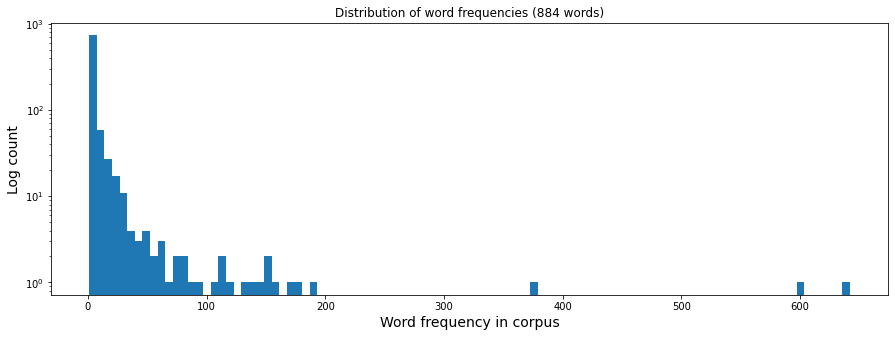

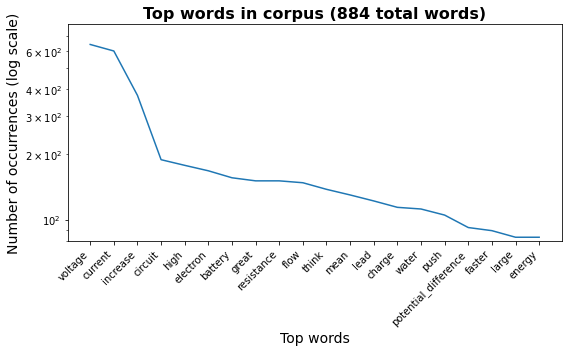

In [13]:
[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq)
fig, ax = plot_words_freq(words, freq)

### Choosing our Filtering Parameters

We want to filter out the extremely common and uncommon words, so we will change values of `no_above` and `no_below` to see which words are removed using different values. 

#### Testing the `no_above` Threshold

In [16]:
no_above_values = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

# NO ABOVE filtering object
id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_above.filter_extremes(no_below=0, no_above=1, keep_n=100000)
print("Dictionary with \033[1mno_above=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_above)))

# Initial Filtering
no_above = 1.0
id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=0, no_above=no_above, keep_n=100000)
diff_set = set(list(id2word_unfiltered_above.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


# Other Values of no_above
for val in no_above_values: 
    no_below = 0
    no_above = val
    id2word_prev = copy.deepcopy(id2word)
    id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
    diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
    print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
          (no_above, len(id2word), len(diff_set), sorted(diff_set)))


Dictionary with no_above=1 contains 885 unique words

Dictionary filtered with no_above=1.00 contains 885 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.90 contains 885 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.80 contains 885 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.70 contains 883 unique words. 2 words removed:
 ['current', 'voltage'] 

Dictionary filtered with no_above=0.60 contains 883 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.50 contains 883 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.40 contains 883 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.30 contains 882 unique words. 1 words removed:
 ['increase'] 

Dictionary filtered with no_above=0.20 contains 872 unique words. 10 words removed:
 ['battery', 'circuit', 'electron', 'flow', 'great', 'high', 'lead', 'mean', 'resistance', 'think'] 

Dictionary filtere

#### Testing the `no_below` Threshold

In [17]:
no_below_values = [i for i in range(2, 30)]# 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1]

# NO BELOW filtering object
id2word_unfiltered_below = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_below.filter_extremes(no_below=1, no_above=no_above, keep_n=100000)
print("Dictionary with \033[1mno_below=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_below)))



# Initial filtering 
no_below = 1
id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
diff_set = set(list(id2word_unfiltered_below.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_below=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_below, len(id2word), len(diff_set), sorted(diff_set)))


# Other values of no_below

for val in no_below_values: 
    no_above = 1
    no_below = val
    id2word_prev = copy.deepcopy(id2word)
    id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
    diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
    print("Dictionary filtered with \033[1mno_below=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
          (no_below, len(id2word), len(diff_set), sorted(diff_set)))

Dictionary with no_below=1 contains 861 unique words

Dictionary filtered with no_below=1.00 contains 861 unique words. 0 words removed:
 [] 

Dictionary filtered with no_below=2.00 contains 399 unique words. 462 words removed:
 ['aa', 'absorbed', 'accept', 'accumulate', 'accumulation', 'accurately', 'achieves', 'actual', 'adjust', 'aircraft', 'aka', 'akin', 'alarm', 'algebra', 'algebraically', 'alleviate', 'amp', 'analogous', 'anyways', 'apology', 'application', 'applies', 'arrow', 'ask', 'assign', 'attack', 'attempt', 'average', 'back', 'badly', 'bae', 'ballssecond', 'bateries', 'batter', 'batterysource', 'bbbbbbbbb', 'bear', 'bed', 'begin', 'bit', 'blub', 'boost', 'bottle', 'boy', 'breach', 'break', 'bridge', 'brightening', 'brightest', 'brought', 'brunk', 'buld', 'burn', 'burning', 'buzzing', 'cabin', 'cancel', 'cap', 'catch', 'caught', 'cave', 'cell', 'chance', 'charger', 'check', 'chemical', 'circulate', 'circut', 'class', 'classify', 'clear', 'cliff', 'cliffmountain', 'cliffmoun

We will choose a `no_above` value of 1 (for now) and a `no_below` value of 3. 

For our `no_above` value, we will choose to exclude the most common words (current and voltage) because if we do not, they will be the most predominant words in each topic, thus skewing the distributions in the LDA model. Because we are trying to characterize student ideas about current and voltage, it's not necessary that we include these terms. If we can relate these words to other terms, perhaps we can extract some useful information. 

For our `no_below` value, we want to include as many words as possible which might lead us toward ideas which students have. We can notice that `no_below=4.00` excludes words such as "mass," "density," "length," "steep," and "property." All of these terms are not directly related to the problem, but provide insight into student ideas. Thus, since we do not want to remove these values, we choose `no_below=3.00`. 

### Creating our Bag of Words

We will now create the bag of words corpus which will be fed to our LDA model in the next section, using the thresholds defined in the previous part. 

Unfiltered Dictionary contains 885 unique words

Applying no_above=0.5 and no_below=3 removes 598 words:
 ['aa', 'absorbed', 'accelerate', 'accept', 'account', 'accumulate', 'accumulation', 'accurate', 'accurately', 'achieves', 'actual', 'actually', 'addition', 'additionally', 'additive', 'adjust', 'affected', 'air', 'aircraft', 'aka', 'akin', 'alarm', 'algebra', 'algebraically', 'alleviate', 'amp', 'analogous', 'anyways', 'apology', 'application', 'applies', 'arrange', 'arrow', 'ask', 'assign', 'associate', 'attack', 'attempt', 'attract', 'attraction', 'average', 'away', 'back', 'badly', 'bae', 'ballssecond', 'bateries', 'batter', 'batterysource', 'bbbbbbbbb', 'bc', 'bear', 'becasue', 'becuase', 'bed', 'begin', 'best', 'bit', 'block', 'blub', 'boost', 'bottle', 'boulder', 'boy', 'breach', 'break', 'bridge', 'bright', 'brightening', 'brightest', 'brought', 'brunk', 'built', 'buld', 'burn', 'burning', 'buzzing', 'cabin', 'calculate', 'cancel', 'cap', 'catch', 'caught', 'cave', 'cell', '

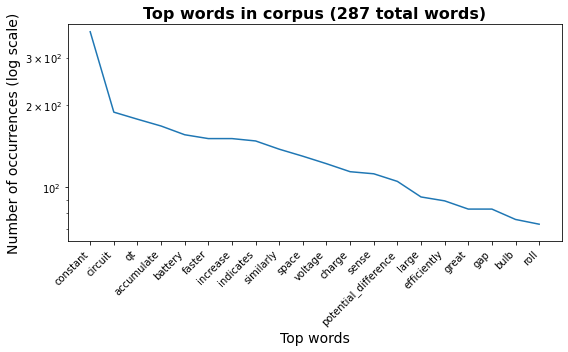

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Top words in corpus (287 total words)'}, xlabel='Top words', ylabel='Number of occurrences (log scale)'>)

In [18]:
no_above = 0.5
no_below = 3

id2word_unfiltered = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
print("Unfiltered Dictionary contains \033[1m{}\033[0m unique words".format(len(id2word_unfiltered)))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered.values())) - set(list(id2word.values()))
print("\nApplying \033[1mno_above={} and no_below={} removes {} words\033[0m:\n {} \n".format(no_above, no_below, len(diff_set), sorted(diff_set)))

id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
print("Filtered Dictionary contains \033[1m{}\033[0m unique words\n".format(len(id2word)))

#Create BoW
bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams]

#Get most frequent words from id2word Dictionary
#There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
[ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
words = [id2word_unfiltered[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!

# Plot distribution
plot_words_freq(words, freq, 20, ylim=None)

These filtering parameters are not necessarily chosen optimally, but rather by intuition of what may yield good topics. Note that choosing different filtering parameters may drastically impact the topics produced by the LDA model.

## III. Topic Modeling

### Training the Model

In [26]:
topic_numbers = [3, 4, 5, 6, 7, 8, 9, 10]

In [27]:
# %%time 
# 
# lda_models = [LdaModel(corpus=bow_corpus, 
#                        id2word=id2word, 
#                        num_topics=num,
#                        alpha='auto',
#                        passes=100, 
#                        random_state=12) 
#               for num in topic_numbers]

In [28]:
# pkl.dump(lda_models, open('lda_models_3-10.pkl', 'wb'))

In [29]:
lda_models = pkl.load(open('pickles/compare_bulbs_3-10.pkl', 'rb'))

In [30]:
for ind, val in enumerate(topic_numbers): 
    print(val, "topics:", "\n")
    lda_models[ind].show_topics(num_words=10, 
                                num_topics = val)
    print("\n\n\n")

3 topics: 



[(0,
  '0.070*"water" + 0.052*"flow" + 0.044*"think" + 0.035*"push" + 0.031*"large" + 0.031*"pressure" + 0.030*"electron" + 0.028*"great" + 0.025*"like" + 0.023*"battery"'),
 (1,
  '0.061*"high" + 0.057*"electron" + 0.041*"charge" + 0.038*"great" + 0.037*"mean" + 0.033*"potential" + 0.029*"faster" + 0.026*"potential_difference" + 0.023*"flow" + 0.023*"energy"'),
 (2,
  '0.138*"increase" + 0.058*"resistance" + 0.052*"circuit" + 0.039*"battery" + 0.031*"bulb" + 0.025*"constant" + 0.023*"lead" + 0.021*"power" + 0.019*"brighter" + 0.017*"ohm_law"')]





4 topics: 



[(0,
  '0.072*"water" + 0.050*"flow" + 0.041*"think" + 0.037*"great" + 0.035*"energy" + 0.034*"pressure" + 0.034*"large" + 0.029*"battery" + 0.027*"electron" + 0.025*"like"'),
 (1,
  '0.058*"electron" + 0.048*"force" + 0.040*"circuit" + 0.035*"mean" + 0.031*"high" + 0.031*"push" + 0.030*"like" + 0.028*"faster" + 0.025*"think" + 0.025*"big"'),
 (2,
  '0.055*"high" + 0.049*"charge" + 0.038*"increase" + 0.037*"electron" + 0.035*"great" + 0.030*"potential_difference" + 0.029*"lead" + 0.028*"mean" + 0.028*"flow" + 0.027*"battery"'),
 (3,
  '0.151*"increase" + 0.068*"resistance" + 0.053*"circuit" + 0.036*"bulb" + 0.034*"battery" + 0.031*"constant" + 0.024*"brighter" + 0.024*"lead" + 0.023*"equation" + 0.021*"ohm_law"')]





5 topics: 



[(0,
  '0.090*"water" + 0.053*"large" + 0.053*"flow" + 0.044*"think" + 0.042*"energy" + 0.040*"pressure" + 0.028*"like" + 0.026*"great" + 0.023*"push" + 0.023*"electron"'),
 (1,
  '0.074*"electron" + 0.057*"force" + 0.044*"great" + 0.041*"high" + 0.038*"big" + 0.033*"mean" + 0.031*"faster" + 0.027*"potential" + 0.023*"push" + 0.022*"think"'),
 (2,
  '0.053*"increase" + 0.052*"high" + 0.050*"charge" + 0.039*"electron" + 0.033*"great" + 0.031*"battery" + 0.029*"lead" + 0.027*"flow" + 0.027*"mean" + 0.026*"potential_difference"'),
 (3,
  '0.081*"battery" + 0.069*"circuit" + 0.069*"power" + 0.048*"bulb" + 0.043*"increase" + 0.036*"brighter" + 0.029*"think" + 0.028*"push" + 0.024*"lead" + 0.022*"double"'),
 (4,
  '0.163*"increase" + 0.083*"resistance" + 0.048*"circuit" + 0.041*"constant" + 0.027*"equation" + 0.024*"mean" + 0.024*"bulb" + 0.024*"ir" + 0.022*"ohm_law" + 0.022*"change"')]





6 topics: 



[(0,
  '0.076*"large" + 0.062*"energy" + 0.045*"great" + 0.042*"flow" + 0.038*"battery" + 0.036*"think" + 0.032*"electron" + 0.028*"potential" + 0.027*"potential_difference" + 0.023*"mean"'),
 (1,
  '0.072*"high" + 0.065*"electron" + 0.049*"force" + 0.049*"great" + 0.043*"mean" + 0.030*"potential" + 0.029*"circuit" + 0.027*"low" + 0.027*"faster" + 0.024*"charge"'),
 (2,
  '0.056*"charge" + 0.053*"increase" + 0.043*"electron" + 0.039*"high" + 0.030*"faster" + 0.030*"lead" + 0.029*"battery" + 0.029*"great" + 0.028*"flow" + 0.028*"potential_difference"'),
 (3,
  '0.080*"power" + 0.069*"circuit" + 0.062*"battery" + 0.052*"increase" + 0.050*"bulb" + 0.045*"push" + 0.041*"brighter" + 0.027*"think" + 0.021*"resistance" + 0.020*"great"'),
 (4,
  '0.177*"increase" + 0.082*"resistance" + 0.043*"circuit" + 0.043*"constant" + 0.029*"equation" + 0.025*"bulb" + 0.025*"ohm_law" + 0.024*"lead" + 0.023*"ir" + 0.021*"change"'),
 (5,
  '0.190*"water" + 0.082*"pressure" + 0.054*"like" + 0.052*"flow" + 0.0





7 topics: 



[(0,
  '0.067*"energy" + 0.059*"large" + 0.046*"flow" + 0.046*"battery" + 0.044*"electron" + 0.037*"think" + 0.033*"great" + 0.027*"circuit" + 0.027*"potential" + 0.026*"potential_difference"'),
 (1,
  '0.057*"great" + 0.052*"mean" + 0.051*"high" + 0.048*"electron" + 0.045*"power" + 0.034*"brighter" + 0.033*"bulb" + 0.031*"think" + 0.030*"circuit" + 0.029*"flow"'),
 (2,
  '0.055*"increase" + 0.053*"high" + 0.044*"lead" + 0.032*"flow" + 0.030*"potential_difference" + 0.026*"wire" + 0.026*"hill" + 0.026*"electron" + 0.024*"resistor" + 0.022*"order"'),
 (3,
  '0.064*"battery" + 0.063*"push" + 0.048*"circuit" + 0.047*"increase" + 0.043*"big" + 0.029*"electron" + 0.026*"flow" + 0.024*"force" + 0.024*"resistance" + 0.020*"add"'),
 (4,
  '0.188*"increase" + 0.086*"resistance" + 0.060*"circuit" + 0.040*"constant" + 0.032*"bulb" + 0.029*"equation" + 0.025*"ir" + 0.023*"change" + 0.023*"stay" + 0.023*"ohm_law"'),
 (5,
  '0.181*"water" + 0.063*"like" + 0.059*"pressure" + 0.050*"flow" + 0.042*"pip





8 topics: 



[(0,
  '0.120*"water" + 0.080*"flow" + 0.063*"think" + 0.045*"pressure" + 0.040*"energy" + 0.036*"electron" + 0.030*"pipe" + 0.029*"like" + 0.027*"large" + 0.024*"potential"'),
 (1,
  '0.060*"power" + 0.055*"circuit" + 0.049*"force" + 0.048*"electron" + 0.045*"directly_proportional" + 0.033*"think" + 0.031*"mean" + 0.030*"resistance" + 0.028*"high" + 0.025*"flow"'),
 (2,
  '0.098*"increase" + 0.053*"lead" + 0.049*"battery" + 0.048*"high" + 0.043*"electron" + 0.029*"flow" + 0.027*"potential_difference" + 0.026*"wire" + 0.026*"difference" + 0.023*"energy"'),
 (3,
  '0.145*"battery" + 0.060*"great" + 0.055*"circuit" + 0.034*"increase" + 0.034*"add" + 0.032*"think" + 0.028*"case" + 0.026*"way" + 0.021*"flow" + 0.021*"source"'),
 (4,
  '0.176*"increase" + 0.096*"resistance" + 0.049*"bulb" + 0.049*"circuit" + 0.042*"constant" + 0.030*"equation" + 0.028*"ir" + 0.027*"brighter" + 0.026*"change" + 0.025*"stay"'),
 (5,
  '0.084*"circuit" + 0.075*"like" + 0.052*"battery" + 0.045*"pump" + 0.045*"d





9 topics: 



[(0,
  '0.084*"battery" + 0.080*"energy" + 0.067*"great" + 0.038*"circuit" + 0.032*"think" + 0.030*"potential_difference" + 0.028*"potential" + 0.026*"electric_potential" + 0.024*"large" + 0.021*"strong"'),
 (1,
  '0.101*"bulb" + 0.095*"power" + 0.083*"high" + 0.070*"resistance" + 0.057*"brighter" + 0.056*"directly_proportional" + 0.043*"mean" + 0.032*"great" + 0.030*"lead" + 0.029*"circuit"'),
 (2,
  '0.067*"increase" + 0.057*"lead" + 0.049*"high" + 0.049*"electron" + 0.043*"battery" + 0.043*"flow" + 0.041*"potential_difference" + 0.033*"think" + 0.026*"wire" + 0.022*"drop"'),
 (3,
  '0.071*"battery" + 0.070*"big" + 0.063*"circuit" + 0.037*"add" + 0.035*"think" + 0.033*"power" + 0.032*"increase" + 0.030*"like" + 0.026*"push" + 0.026*"brighter"'),
 (4,
  '0.232*"increase" + 0.099*"resistance" + 0.055*"circuit" + 0.051*"constant" + 0.036*"equation" + 0.030*"ir" + 0.027*"ohm_law" + 0.027*"change" + 0.026*"vr" + 0.024*"stay"'),
 (5,
  '0.144*"water" + 0.109*"pressure" + 0.065*"like" + 0.0





10 topics: 



[(0,
  '0.066*"energy" + 0.058*"think" + 0.054*"battery" + 0.050*"circuit" + 0.049*"great" + 0.037*"large" + 0.034*"difference" + 0.028*"flow" + 0.025*"potential" + 0.023*"like"'),
 (1,
  '0.107*"force" + 0.102*"electron" + 0.076*"mean" + 0.051*"potential_difference" + 0.047*"push" + 0.040*"circuit" + 0.035*"great" + 0.033*"faster" + 0.024*"resistance" + 0.024*"directly_proportional"'),
 (2,
  '0.105*"lead" + 0.067*"electron" + 0.061*"potential_difference" + 0.055*"high" + 0.055*"increase" + 0.036*"wire" + 0.033*"flow" + 0.032*"battery" + 0.030*"drop" + 0.025*"energy"'),
 (3,
  '0.368*"increase" + 0.079*"resistance" + 0.068*"constant" + 0.050*"circuit" + 0.050*"ir" + 0.034*"stay" + 0.028*"lead" + 0.015*"turn" + 0.013*"source" + 0.013*"long"'),
 (4,
  '0.092*"increase" + 0.065*"resistance" + 0.056*"bulb" + 0.049*"circuit" + 0.042*"brighter" + 0.036*"battery" + 0.036*"equation" + 0.034*"power" + 0.029*"mean" + 0.029*"ohm_law"'),
 (5,
  '0.090*"circuit" + 0.067*"vr" + 0.058*"pump" + 0.057

### Evaluating Model Coherence

In [31]:
coherences = [CoherenceModel(model = model, 
                             texts = data_words_bigrams, 
                             dictionary = id2word, 
                             coherence = 'c_v').get_coherence()
              for model in lda_models]

In [32]:
for ind, val in enumerate(topic_numbers): 
    print("Coherence of model with {} topics:".format(val), 
          coherences[ind], "\n")

Coherence of model with 3 topics: 0.4624821002177489 

Coherence of model with 4 topics: 0.44896074898627686 

Coherence of model with 5 topics: 0.4625408941484136 

Coherence of model with 6 topics: 0.4545947105475539 

Coherence of model with 7 topics: 0.41926448306461944 

Coherence of model with 8 topics: 0.4111275113328625 

Coherence of model with 9 topics: 0.4175545843611398 

Coherence of model with 10 topics: 0.42018663923405536 



### Representative Responses for each Topic

We'll choose the number of topics automatically according to whichever topic number yielded the highest coherence value.

In [33]:
best_ind = np.argmax(coherences) # Choose the model which maximizes coherence
# best_ind = 2

num_topics = topic_numbers[best_ind]
lda_model = lda_models[best_ind]

print("For this analysis, we choose the {} topic model, with a coherence of {}".format(num_topics, coherences[best_ind]))

For this analysis, we choose the 5 topic model, with a coherence of 0.4625408941484136


In [34]:
best_ind

2

In [35]:
def get_weight_in_doc(ldamodel, corpus, doc_num, fill=0):
    """ Get the weigth for each topic in a document
    Inputs: ldamodel, corpus, doc_num, fill (value when topic was not found)
    Output: list of tuples [(<topic number>, <topic weight>)]
    """
    num_topics = ldamodel.num_topics
    weights = [fill] * num_topics
    # Get a list of tuples with the detected topics and weights
    row = ldamodel[corpus][doc_num]
    # Process the output to return a list of weights
    tw = list(zip(*row))
    for topic in range(num_topics):
        if topic in tw[0]:
            ind = tw[0].index(topic)
            weights[topic] = tw[1][ind]
    return weights

def get_weight_per_doc(ldamodel, corpus):
    """ Get a document by topic weight Dataframe 
    Inputs: ldamodel, corpus
    """
    num_topics = ldamodel.num_topics
    dataframe = pd.DataFrame(np.zeros((len(corpus),num_topics)), columns=list(range(num_topics)))
    dataframe.index.name = 'Topic weights'
    for i, row in dataframe.iterrows():
        dataframe.iloc[i] = pd.Series(get_weight_in_doc(ldamodel, corpus, i))
    return dataframe

weights = get_weight_per_doc(lda_model, bow_corpus)

df_weighted = pd.concat([df, weights], axis = 1)

In [36]:
df_weighted.head(5)

,resp,replaced,0,1,2,3,4
0,Circuit 2 has a larger battery that has a grea...,Circuit 2 has a larger battery that has a grea...,0.471262,0.000000,0.182775,0.336412,0.000000
1,If the voltage is increased but resistance rem...,If the voltage is increased but resistance rem...,0.000000,0.000000,0.011220,0.000000,0.970128
2,Current is equal to charge over time. Move vol...,Current is equal to charge over time Move volt...,0.000000,0.312728,0.664570,0.000000,0.010863
3,An increase in voltage indicates an increase i...,An increase in voltage indicates an increase i...,0.011598,0.000000,0.271025,0.000000,0.699866
4,Voltage is the change in electric potential. C...,Voltage is the change in electric potential Cu...,0.000000,0.000000,0.975137,0.000000,0.000000


In [37]:
def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

num_responses_displayed = 3

for t in range(num_topics): 
    print('Topic {}: {}'.format(t, lda_model.print_topics(num_words=10)[t][1]))
    pretty_print(df_weighted.sort_values(by=t, ascending=False).loc[:, df_weighted.columns!='replaced'][:num_responses_displayed])
    print('\n\n')    

Topic 0: 0.090*"water" + 0.053*"large" + 0.053*"flow" + 0.044*"think" + 0.042*"energy" + 0.040*"pressure" + 0.028*"like" + 0.026*"great" + 0.023*"push" + 0.023*"electron"


,resp,0,1,2,3,4
219,"I use the metal model of a river or lake filled with water. Water flows through a river like current flows through circuits. If you think of potential difference in terms of a river or lake, when one end of the river is higher than the other the water flows more and with more current. There is a greater gravitational potential difference between the two river ends. It is the same with electricity, when the electric potential is greater, more current can flow. More electron are allowed to flow.",0.991588,0.0,0.0,0.0,0.0
460,"More voltage leads to more current, because if there is more potential (or, less accurately, pressure) for electron flow, and the resistance remains constant, more electrons will flow. An analogy would be putting your finger over a hose to create a pressurized stream. If you then crank the water up, more water will spray out, and it will spray out faster. I don't understand exactly what the question means by mental models, besides the water hose analogy given. My apologies if this isn't what was intended.",0.989432,0.0,0.0,0.0,0.0
401,"I think more voltage leads to more current because larger the change voltage the stronger the electric current. I use the mental model of a pressurized container or aircraft. If this aircraft is in an area of different pressure, and if there is a hull breach the air inside the craft will equalize outside. Depending on how much pressure there is compared to the outside it can be especially violent and quick. The difference in pressure in the example is the voltage, and the bigger the difference the stronger and more violent the cabin will equalize.",0.985066,0.0,0.0,0.0,0.0





Topic 1: 0.074*"electron" + 0.057*"force" + 0.044*"great" + 0.041*"high" + 0.038*"big" + 0.033*"mean" + 0.031*"faster" + 0.027*"potential" + 0.023*"push" + 0.022*"think"


,resp,0,1,2,3,4
101,"More voltage leads to more current because it has a higher potential. Think about the electrons like holding something off the ground. The object wants to be on the ground because it is pulled by gravity, giving it potential. This is the same for the electrons. The electrons want to be near the positive terminal so they too have potential. The more potential (the higher off the ground) means the more force there is pulling it to where it wants to be, which means there must be more electrons to flow.",0.0,0.990241,0.0,0.0,0.0
144,"Since voltage basically ""pulls"" electrons across the area of different potentials, more voltage basically results in a harder pull, and therefore the electrons speed up more. Since current is just a measure of how many electrons (or other charger carrier) move through an area every second, faster electrons will result in a higher current. Therefore, more voltage equals more current.",0.0,0.986311,0.0,0.0,0.0
313,"Because more voltage means a higher difference in potential (essentially, a longer 'fall', if comparing it to potential energy due to gravity), the electrons/particles will be moving faster at the end of the fall. Current is proportional to the speed of the electrons/particles moving, so faster movement correlates to a higher current.",0.0,0.984965,0.0,0.0,0.0





Topic 2: 0.053*"increase" + 0.052*"high" + 0.050*"charge" + 0.039*"electron" + 0.033*"great" + 0.031*"battery" + 0.029*"lead" + 0.027*"flow" + 0.027*"mean" + 0.026*"potential_difference"


,resp,0,1,2,3,4
157,"More voltage leads to more current because there exists a potential difference across the battery that must be matched through the circuit. This difference ""pushes"" the free electrons through the wire and resistor, creating what we call current. Since delta V must be matched between the battery and circuit, else a build up of charge resulting, more voltage must indicate more current if the resistance remains the same (this, again though, is by Ohm's Law). The relationship between voltage and current can also be understood through the context of electric fields and forces. The electric potential difference denoted on a battery is chemically generated by work done on electrons such that an electric dipole is generated. This dipole creates a net electric field around the circuit, which pushes already (randomly) moving electrons in a general direction - this creates drift velocity. The faster this drift velocity - as a result of a stronger E-field corresponding to more voltage - the more electrons pass through a certain cross section of the wire in a given amount of time. This is the very definition of current (delta Q / delta t). Ultimately, a greater voltage corresponds with a greater magnitude electric field. A greater magnitude electric field yields a larger drift velocity, which in turn increases the amount of charge that passes through a cross section of the circuit in any given amount of time - effectively, it increases the current (brightening the bulb).",0.0,0.0,0.996672,0.0,0.0
39,"The way that I think about this is that in order for the battery to maintain a certain potential difference between its terminals, it needs to generate an electric field that will ""push"" charges. In order to make the potential difference greater, this field needs to be stronger, which means it will ""push"" harder. Consequently, a stronger push means charges are going to move faster, and since current is the amount of charge moving past per unit time, faster moving charges means greater current.",0.0,0.0,0.993111,0.0,0.0
56,"The role of a battery is to maintain a fixed electric potential difference between its terminals. If the voltage of the battery increases, the potential difference that the battery must maintain increases. So, the battery must push more charge through it to maintain the voltage. Current is the amount of charge that flows per unit time. If the total amount of charge has increased, the current has also increased. I am visualizing the battery itself, and connecting the fact that increasing the voltage also increases the capacity of a battery to chemically react and release electrons.",0.0,0.0,0.992508,0.0,0.0





Topic 3: 0.081*"battery" + 0.069*"circuit" + 0.069*"power" + 0.048*"bulb" + 0.043*"increase" + 0.036*"brighter" + 0.029*"think" + 0.028*"push" + 0.024*"lead" + 0.022*"double"


,resp,0,1,2,3,4
339,I think about this in two ways. First in Circuit 1and 2 the Resistence is the same since they are Identical batteries. Since Circuit 2 has a second battery added it doubles the voltage. Since R is the same the I is force to increase. and Increasing the Current increases the power. The way I think about the Current increasing is one battery is producing a certain amount of current which so if you add another battery it will be looking at its V and the R producing more of a current. the total Current can be found by adding the two together.,0.0,0.0,0.0,0.988944,0.0
112,"In this scenario I think of the Voltage as the amount of current crossing a resistor. Although voltage does not flow like current the higher the voltage the more current will flow across the resistor because of ohm's law. As far as picturing the bulb brighter or dimmer, it is intuitive in my opinion that a brighter bulb represents more power and therefore more current. I also like to think of it as a lot of electrons flying through the filament in the buld making it glow and emit light.",0.0,0.0,0.0,0.987049,0.0
328,"Well since there is more power that goes through bulb 2, it should be brighter. I think of the electricity that goes through the circuits, and how powerful each one is. Circuit 1 has less voltage so I think of a small amount of electricity, while circuit 2 has fast, power surge of electricity.",0.0,0.0,0.0,0.982573,0.0





Topic 4: 0.163*"increase" + 0.083*"resistance" + 0.048*"circuit" + 0.041*"constant" + 0.027*"equation" + 0.024*"mean" + 0.024*"bulb" + 0.024*"ir" + 0.022*"ohm_law" + 0.022*"change"


,resp,0,1,2,3,4
280,"Because the resistance is the same in both circuit 1 and circuit 2, when the voltage is increased (as in circuit 2) the current must also proportionally increase, and thus the lightbulb will be brighter when voltage is increased. I just think about this in terms of the equation, so for example lets say the voltage in circuit 1 is V and the voltage in circuit 2 is 2V, and so the equation for the current in circuit 1 would be (V/R)=I and to get to circuit 2 you're basically just multiplying both sides by 2 (and keeping R constant) and you end up with (2V/R)=2I, and so the current proportionally increases with the voltage(the brightness of the bulb is dependent on the current flowing through it, so when the current increases, the brightness also increases).",0.0,0.0,0.0,0.0,0.992943
99,"Ohm's law states that the electrical current (I) flowing in an circuit is proportional to the voltage (V) and inversely proportional to the resistance (R). Therefore, if the voltage is increased, the current will increase provided the resistance of the circuit does not change. In a linear circuit of fixed resistance, if we increase the voltage, the current goes up, and similarly, if we decrease the voltage, the current goes down. This means that if the voltage is high the current is high, and if the voltage is low the current is low.",0.0,0.0,0.0,0.0,0.990879
411,"A higher voltage would result in a higher current, proven by rearranging the equation V=IR. I usually think about it in terms of the equation, sometime drawing arrows for each of the variable indicating how a change in one value affects the other. For this case I look at V and draw an up arrow, then can conclude that if R is constant, I must also increase.",0.0,0.0,0.0,0.0,0.987108


### Interpretation of Topics as Student Ideas

From the topic outputs above, it seems like we can extract a few distinct student ideas: 

0. "Water flows through a river like current flows through circuits"

1. "More voltage means a higher difference in potential," which can be thought of like potential energy

2. Batteries create a fixed voltage/potential difference, and increasing voltage increases "electron flow"

3. Adding a battery increases voltage, which increases current

4. Ohm's Law says that Voltage is proportional to Current, so increasing the voltage should increase the current.
    